# Denoising autoencoder -- ConvNet implementation

### Download data

In [3]:
!wget -O SVHN.mat http://ufldl.stanford.edu/housenumbers/train_32x32.mat # download SVHN dataset
!mkdir datasets # create dataset dir
!mv SVHN.mat datasets # move SVHN data to dataset dir

--2020-05-15 21:08:07--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘SVHN.mat’

SVHN.mat            100%[===================>] 173.61M  56.3MB/s    in 3.4s    

2020-05-15 21:08:11 (51.2 MB/s) - ‘SVHN.mat’ saved [182040794/182040794]



### Imports

In [0]:
import numpy as np # numpy for matrix operations
import math # math for mathematical operations
import scipy.io # scipy for loading data

# keras layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ReLU
from keras.losses import MSE
from keras import regularizers

### Read images

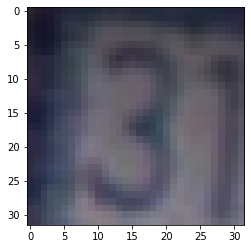

In [15]:
images = np.rollaxis(np.array(scipy.io.loadmat("datasets/SVHN.mat")['X']), axis = 3, start=0) #read and reshape images
plt.imshow(images[8]) # show sample image

### Create noisy images

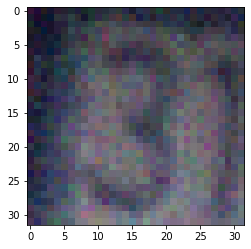

In [16]:
noise = np.random.binomial(400, 0.5, images.shape)-200 # generate gaussian noise
noisy_images = images + noise # add noise to data
plt.imshow(noisy_images[8]) # show sample noisy image

### Add salt/pepper noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


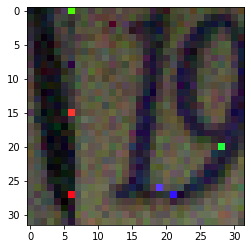

In [17]:
mask = np.random.randint(0,1000,size=noisy_images.shape).astype(np.bool) # generate pepper noise
noisy_images *= mask # add pepper noise

noisy_images = 255-noisy_images # invert image

mask = np.random.randint(0,1000,size=noisy_images.shape).astype(np.bool) # repeat for salt noise
noisy_images *= mask

noisy_images = 255-noisy_images # invert again

plt.imshow(noisy_images[0]) # show image

### Split dataset

In [0]:
split = math.floor(0.9*len(images)) # split dataset to train and val

val_images = images[split:]
val_noisy_images = noisy_images[split:]

images = images[:split]
noisy_images = noisy_images[:split]

### Normalize data

In [0]:
avg = np.average(noisy_images) # calculate mean
std = np.std(noisy_images) # calculate std

noisy_images_downscaled  = (noisy_images - avg) / std # normalize data (standard norm.)
val_noisy_images_downscaled = (val_noisy_images - avg) / std

### Define model

In [0]:
# convolutional implementation of the autoencoder
class Autoencoder():
    # parameters: nubmer of conv levels, layers per level, thickness of layers
    def __init__(self, levels, layers, thickness, n):
        super(Autoencoder, self).__init__()
        self.levels = levels
        self.layers = layers
        self.n = n
        self.thickness = thickness
        self.__built = False

    # this method builds the autoencoder
    # automatically called on first forward pass or summary
    def __build(self, X):
        self.__model = Sequential() # sequetnial model
        for level in range(self.levels): # calculate convolutional layer sizes and create the layers
            for layer in range(self.layers):
                if level == 0 and layer == 0:
                    # l2 reg to avoid overfitting
                    self.__model.add(Conv2D(self.thickness*(2**level), kernel_size=(self.n, self.n), padding="same", input_shape=X.shape[1:4], name=f"encoder_conv{level}_{layer}", kernel_regularizer=regularizers.l2(1e-6), bias_regularizer=regularizers.l2(1e-6)))
                else:
                    self.__model.add(Conv2D(self.thickness*(2**level), kernel_size=(self.n, self.n), padding="same", name=f"encoder_conv{level}_{layer}"))
                self.__model.add(ReLU(name=f"encoder_relu{level}_{layer}")) # relu to avoid loss of gradient
            self.__model.add(MaxPooling2D(pool_size=(2,2), name=f"encoder_maxpool{level}")) # maxpool reduces dimensionality
        for level in reversed(range(self.levels)):
            for layer in range(self.layers):
                self.__model.add(Conv2D(self.thickness*(2**level), kernel_size=(self.n, self.n), padding="same", name=f"decoder_conv{level}_{layer}", kernel_regularizer=regularizers.l2(1e-6), bias_regularizer=regularizers.l2(1e-6)))
                self.__model.add(ReLU(name=f"decoder_relu{level}_{layer}"))
            self.__model.add(UpSampling2D(size=(2,2), name=f"decoder_upsampling{level}"))
        self.__model.add(Conv2D(X.shape[3], kernel_size=(self.n, self.n), padding="same", name="final_conv"))
        self.__model.compile(loss=['mse'], optimizer="adam")
        self.__built = True

    # forward pass
    # __call__ should be called instead
    def forward(self, X, Y_target):
        if not self.__built:
            self.__build(X)
        loss = self.__model.train_on_batch(X, Y_target)
        return loss
    
    # print model summary
    def summary(self):
        assert self.__built, "Build model first by passing a tensor to it."
        self.__model.summary()
    
    # forward pass, no training is performed    
    def predict(self, X):
        return self.__model.predict(X)

    # set trainability of network (does not require rebuild)
    def trainable(self, val):
        if not self.__built:
            self.__build(X)
        for layer in self.__model.layers:
            layer.trainable = val


### Train model

In [22]:
model = Autoencoder(levels = 3, layers = 1, thickness = 10, n = 3) # create model
epochs = 200 # number of epochs
batch_size = 12 # batch size for mini-batching
lr = 0.00005 # learning rate

loss_history = [] # loss history for plotting
val_loss_history = []

batches = math.ceil(images.shape[0] / batch_size) # calculate number of batches
val_batches = math.ceil(val_images.shape[0] / batch_size)

for e in range(epochs):
    loss_total = 0
    for b in range(batches): # pass all batches through the network
        # before forward step, create the input and target batches
        X = noisy_images_downscaled[batch_size*b:batch_size*(b+1)]
        Y_target = images[batch_size*b:batch_size*(b+1)]
        
        model.trainable(True) # enable training
        loss = model.forward(X, Y_target) # forward step

        loss_total += loss

    loss_avg = loss_total / (batches*batch_size) # calculate avg loss
    loss_history.append(loss_avg)
    print(f"epoch {e} -- loss: {loss_avg}", end="")

    val_loss_total = 0
    for b in range(val_batches): # repeat for the val dataset
        X = val_noisy_images_downscaled[batch_size*b:batch_size*(b+1)]
        Y_target = val_images[batch_size*b:batch_size*(b+1)]

        model.trainable(False)
        val_loss = model.forward(X, Y_target)

        val_loss_total += val_loss

    val_loss_avg = val_loss_total / (val_batches*batch_size)
    val_loss_history.append(val_loss_avg)
    print(f" -- val_loss: {val_loss_avg}")


epoch 0 -- loss: 52.321821583940796

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


 -- val_loss: 23.96794673359856
epoch 1 -- loss: 18.941605818542815 -- val_loss: 14.610219854509902
epoch 2 -- loss: 13.503102261129929 -- val_loss: 11.561773435964131
epoch 3 -- loss: 11.36483972877454 -- val_loss: 10.2331133476711
epoch 4 -- loss: 10.210119607559218 -- val_loss: 9.375111340045668
epoch 5 -- loss: 9.420780778704971 -- val_loss: 8.807422444395074
epoch 6 -- loss: 8.911021082047661 -- val_loss: 8.21810125016932
epoch 7 -- loss: 8.445862256999735 -- val_loss: 7.942443604685216
epoch 8 -- loss: 8.156589466461746 -- val_loss: 7.729566327483681
epoch 9 -- loss: 7.913042509248483 -- val_loss: 7.48861354592714
epoch 10 -- loss: 7.760883446190984 -- val_loss: 7.211036835611679
epoch 11 -- loss: 7.574084871365585 -- val_loss: 7.116593584101251
epoch 12 -- loss: 7.452381292892146 -- val_loss: 6.9589911318839865
epoch 13 -- loss: 7.245083278578486 -- val_loss: 7.089792211005029
epoch 14 -- loss: 7.2312653999745145 -- val_loss: 6.737093070655069
epoch 15 -- loss: 7.156204724246746

KeyboardInterrupt: ignored

### Model summary

In [23]:
model.summary() # print model summary

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_conv0_0 (Conv2D)     (None, 32, 32, 10)        280       
_________________________________________________________________
encoder_relu0_0 (ReLU)       (None, 32, 32, 10)        0         
_________________________________________________________________
encoder_maxpool0 (MaxPooling (None, 16, 16, 10)        0         
_________________________________________________________________
encoder_conv1_0 (Conv2D)     (None, 16, 16, 20)        1820      
_________________________________________________________________
encoder_relu1_0 (ReLU)       (None, 16, 16, 20)        0         
_________________________________________________________________
encoder_maxpool1 (MaxPooling (None, 8, 8, 20)          0         
_________________________________________________________________
encoder_conv2_0 (Conv2D)     (None, 8, 8, 40)         

### Loss history

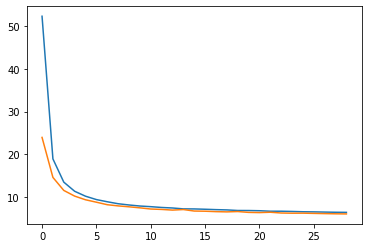

In [24]:
plt.plot(loss_history) # plot loss history
plt.plot(val_loss_history)

### Results

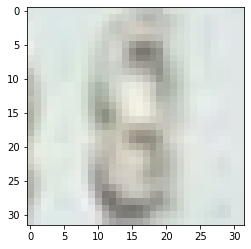

In [25]:
plt.imshow(val_images[2]) # sample image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


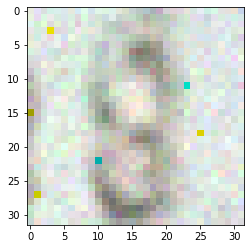

In [26]:
plt.imshow(val_noisy_images[2]) # sample noisy image

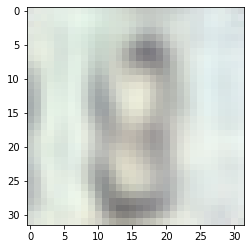

In [27]:
[pred] = model.predict(val_noisy_images_downscaled[2:3]) # pass a barch through the network
pred = np.array(np.rint(pred), dtype=int) # create denoised image
pred = np.where(pred > 255, 255, pred) # filter out too large values
pred = np.where(pred < 0, 0, pred) # filter out negative values
plt.imshow(pred) # show filtered image